In [ ]:
!pip install --upgrade pip setuptools >/dev/null
!pip install kaggle librosa soundfile tensorflow matplotlib scikit-learn tqdm >/dev/null
!pip install tensorflow_hub >/dev/null

import os, shutil, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa, soundfile as sf
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from google.colab import files

print("Packages installed and imported.")


In [ ]:
DATA_ROOT = Path("/content/audio_data")
DRONE_DIR = DATA_ROOT / "drone"
NOISE_DIR = DATA_ROOT / "noise"

for p in [DATA_ROOT, DRONE_DIR, NOISE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

def safe_load_audio(path, sr=16000, duration=1.0):
    """Load audio, mono, pad/trim to duration seconds."""
    try:
        audio, orig_sr = librosa.load(str(path), sr=sr, mono=True)
    except Exception as e:
        try:
            audio, orig_sr = sf.read(str(path))
            if audio.ndim > 1:
                audio = np.mean(audio, axis=1)
            if orig_sr != sr:
                audio = librosa.resample(audio, orig_sr, sr)
        except Exception as e2:
            print(f"ERROR loading {path}: {e2}")
            return None
    target_len = int(sr * duration)
    if len(audio) < target_len:
        audio = np.pad(audio, (0, target_len - len(audio)))
    else:
        audio = audio[:target_len]
    return audio


In [ ]:
print("Step: Download datasets...")

DRONE_GIT = "https://github.com/saraalemadi/DroneAudioDataset.git"
if not (DRONE_DIR.exists() and any(DRONE_DIR.iterdir())):
    print("Cloning Drone dataset...")
    !git clone --depth 1 {DRONE_GIT} /content/drone_repo >/dev/null 2>&1 || true
    if Path("/content/drone_repo/Binary_Drone_Audio/yes_drone").exists():
        shutil.copytree("/content/drone_repo/Binary_Drone_Audio/yes_drone", DRONE_DIR, dirs_exist_ok=True)
    if Path("/content/drone_repo/Binary_Drone_Audio/unknown").exists():
        shutil.copytree("/content/drone_repo/Binary_Drone_Audio/unknown", NOISE_DIR, dirs_exist_ok=True)
    print("✅ Drone dataset prepared.")

print("Dataset preparation finished.")
print(f"Drone samples: {len(list(DRONE_DIR.glob('**/*')))}")
print(f"Noise samples: {len(list(NOISE_DIR.glob('**/*')))}")


In [ ]:
print("\nStep: Extracting YAMNet embeddings...")

yamnet_model_handle = "https://tfhub.dev/google/yamnet/1"
yamnet_model = hub.load(yamnet_model_handle)

def extract_embedding(audio, sr=16000):
    """Extract YAMNet embedding for one audio clip."""
    scores, embeddings, spectrogram = yamnet_model(audio)
    # Average embeddings over time
    return tf.reduce_mean(embeddings, axis=0).numpy()

def gather_audio_files(folder):
    exts = ("*.wav","*.WAV","*.mp3","*.MP3","*.flac","*.FLAC")
    files_list = []
    for e in exts:
        files_list.extend(folder.glob("**/" + e))
    return files_list

drone_files = gather_audio_files(DRONE_DIR)
noise_files = gather_audio_files(NOISE_DIR)

print(f"Found {len(drone_files)} drone, {len(noise_files)} noise files.")

X_list, y_list = [], []

for f in tqdm(drone_files, desc="Drone"):
    audio = safe_load_audio(f, sr=16000, duration=1.0)
    if audio is None: continue
    emb = extract_embedding(tf.convert_to_tensor(audio, dtype=tf.float32))
    X_list.append(emb); y_list.append(0)

for f in tqdm(noise_files, desc="Noise"):
    audio = safe_load_audio(f, sr=16000, duration=1.0)
    if audio is None: continue
    emb = extract_embedding(tf.convert_to_tensor(audio, dtype=tf.float32))
    X_list.append(emb); y_list.append(1)

X = np.array(X_list)
y = np.array(y_list)
print("Final dataset:", X.shape, y.shape)

# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

# Class weights
classes = np.unique(y)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)


In [ ]:
print("\nStep: Training classifier on embeddings...")

input_shape = X_train.shape[1:]

classifier = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(2, activation="softmax")
])

classifier.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
classifier.summary()

EPOCHS = 20
BATCH = 32
es = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH,
    callbacks=[es],
    class_weight=class_weight_dict
)

MODEL_PATH = "/content/yamnet_drone_classifier.h5"
classifier.save(MODEL_PATH)
print(f"\nModel saved to: {MODEL_PATH}")


In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()

test_loss, test_acc = classifier.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")

y_pred_probs = classifier.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
labels = ["Drone", "Noise"]
print("\nClassification Report:")
print(classification_report(y_test, y_Apred, target_names=labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
import pandas as pd

classes = ["Drone", "Noise"]

def classify_file_yamnet(file_path, sr=16000):
    audio = safe_load_audio(file_path, sr=sr, duration=1.0)
    if audio is None: return None
    emb = extract_embedding(tf.convert_to_tensor(audio, dtype=tf.float32))[np.newaxis, :]
    probs = classifier.predict(emb, verbose=0)[0]
    return {
        "Prediction": classes[np.argmax(probs)],
        "Drone %": round(probs[0]*100, 1),
        "Noise %": round(probs[1]*100, 1),
    }

while True:
    print("\n>>> Upload a file (wav/mp3/flac) or STOP to exit.")
    uploaded = files.upload()
    if not uploaded: break
    for fname in uploaded.keys():
        print(f"\nProcessing {fname}...")
        result = classify_file_yamnet(fname)
        print(result)
    cont = input("Test another file? (y/n): ").strip().lower()
    if cont != "y":
        print("✅ Testing finished.")
        break


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


/usr/local/lib/python3.12/dist-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


Packages installed and imported.
Step: Download datasets...
Cloning Drone dataset...
✅ Drone dataset prepared.
Dataset preparation finished.
Drone samples: 1332
Noise samples: 10372

Step: Extracting YAMNet embeddings...
Found 1332 drone, 10372 noise files.


Noise: 100%|██████████| 10372/10372 [03:39<00:00, 47.19it/s]


Final dataset: (11704, 1024) (11704,)
Train/Val/Test sizes: 8778 1463 1463
Class weights: {np.int64(0): np.float64(4.393393393393393), np.int64(1): np.float64(0.56421133821828)}

Step: Training classifier on embeddings...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,458 (513.51 KB)

 Trainable params: 131,458 (513.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8951 - loss: 0.3136 - val_accuracy: 0.9556 - val_loss: 0.1558
Epoch 2/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9475 - loss: 0.1999 - val_accuracy: 0.9364 - val_loss: 0.1740
Epoch 3/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9518 - loss: 0.1106 - val_accuracy: 0.9720 - val_loss: 0.1237
Epoch 4/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9596 - loss: 0.1143 - val_accuracy: 0.9658 - val_loss: 0.1126
Epoch 5/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9633 - loss: 0.1136 - val_accuracy: 0.9501 - val_loss: 0.1300
Epoch 6/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9670 - loss: 0.0844 - val_accuracy: 0.9617 - val_loss: 0.1161
Epoch 7/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9747 - loss: 0.0692 - val_accuracy: 0.9679 - val_loss: 0.0955
Epoch 8/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9701 - loss: 0.0758 - val_accuracy: 0


Model saved to: /content/yamnet_drone_classifier.h5


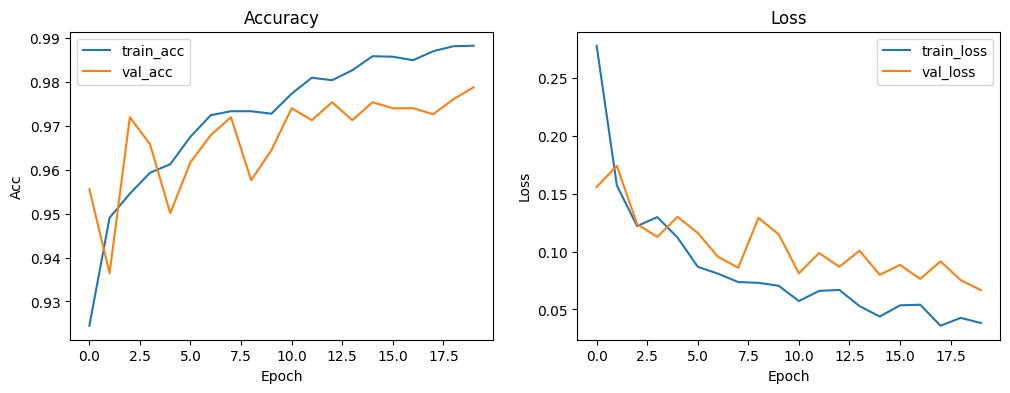


Final Test Accuracy: 98.43% | Test Loss: 0.0399
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

       Drone       0.90      0.97      0.93       167
       Noise       1.00      0.99      0.99      1296

    accuracy                           0.98      1463
   macro avg       0.95      0.98      0.96      1463
weighted avg       0.99      0.98      0.98      1463

Confusion Matrix:
[[ 162    5]
 [  18 1278]]

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving drone-noise-01-321269.mp3 to drone-noise-01-321269.mp3

Processing drone-noise-01-321269.mp3...
{'Prediction': 'Drone', 'Drone %': np.float32(100.0), 'Noise %': np.float32(0.0)}
Test another file? (y/n): y

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving drone-noise-01-321269.mp3 to drone-noise-01-321269 (1).mp3

Processing drone-noise-01-321269 (1).mp3...
{'Prediction': 'Drone', 'Drone %': np.float32(100.0), 'Noise %': np.float32(0.0)}
Test another file? (y/n): y

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving burghrecords__birds-singing-forest-scotland(chosic.com).mp3 to burghrecords__birds-singing-forest-scotland(chosic.com).mp3

Processing burghrecords__birds-singing-forest-scotland(chosic.com).mp3...
{'Prediction': 'Noise', 'Drone %': np.float32(0.0), 'Noise %': np.float32(100.0)}
Test another file? (y/n): y

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving Voicy_Drone Racing Sound.mp3 to Voicy_Drone Racing Sound.mp3

Processing Voicy_Drone Racing Sound.mp3...
{'Prediction': 'Noise', 'Drone %': np.float32(0.0), 'Noise %': np.float32(100.0)}
Test another file? (y/n): y

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving 103060-15_YIPxu7ly.wav to 103060-15_YIPxu7ly.wav

Processing 103060-15_YIPxu7ly.wav...
{'Prediction': 'Noise', 'Drone %': np.float32(0.0), 'Noise %': np.float32(100.0)}
Test another file? (y/n): y

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving DRONE_024 (1).wav to DRONE_024 (1).wav

Processing DRONE_024 (1).wav...
{'Prediction': 'Drone', 'Drone %': np.float32(53.0), 'Noise %': np.float32(47.0)}
Test another file? (y/n): y

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving drone-024_TKHalS7J.wav to drone-024_TKHalS7J.wav

Processing drone-024_TKHalS7J.wav...
{'Prediction': 'Drone', 'Drone %': np.float32(100.0), 'Noise %': np.float32(0.0)}
Test another file? (y/n): y

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving 103060-15_YIPxu7ly.wav to 103060-15_YIPxu7ly (1).wav

Processing 103060-15_YIPxu7ly (1).wav...
{'Prediction': 'Noise', 'Drone %': np.float32(0.0), 'Noise %': np.float32(100.0)}
Test another file? (y/n): y

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving audiomass-output (4).mp3 to audiomass-output (4).mp3

Processing audiomass-output (4).mp3...
{'Prediction': 'Drone', 'Drone %': np.float32(100.0), 'Noise %': np.float32(0.0)}
Test another file? (y/n): y

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving audiomass-output (2).mp3 to audiomass-output (2).mp3

Processing audiomass-output (2).mp3...
{'Prediction': 'Noise', 'Drone %': np.float32(0.0), 'Noise %': np.float32(100.0)}
Test another file? (y/n): y

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving humming-bird-333662 (1).mp3 to humming-bird-333662 (1).mp3

Processing humming-bird-333662 (1).mp3...
{'Prediction': 'Noise', 'Drone %': np.float32(0.2), 'Noise %': np.float32(99.8)}
Test another file? (y/n): y

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving audiomass-output (1).mp3 to audiomass-output (1).mp3

Processing audiomass-output (1).mp3...
{'Prediction': 'Drone', 'Drone %': np.float32(100.0), 'Noise %': np.float32(0.0)}
Test another file? (y/n): y

>>> Upload a file (wav/mp3/flac) or STOP to exit.


Saving flying-drone-whoosh-1-185324.mp3 to flying-drone-whoosh-1-185324.mp3

Processing flying-drone-whoosh-1-185324.mp3...
{'Prediction': 'Noise', 'Drone %': np.float32(43.5), 'Noise %': np.float32(56.5)}


KeyboardInterrupt: Interrupted by user

In [ ]:

import pandas as pd

classes = ["Drone", "Noise"]

def classify_file_yamnet(file_path, sr=16000):
    audio = safe_load_audio(file_path, sr=sr, duration=1.0)
    if audio is None: return None
    emb = extract_embedding(tf.convert_to_tensor(audio, dtype=tf.float32))[np.newaxis, :]
    probs = classifier.predict(emb, verbose=0)[0]
    return {
        "Prediction": classes[np.argmax(probs)],
        "Drone %": round(probs[0]*100, 1),
        "Noise %": round(probs[1]*100, 1),
    }

while True:
    print("\n>>> Upload a file (wav/mp3/flac) or STOP to exit.")
    uploaded = files.upload()
    if not uploaded: break
    for fname in uploaded.keys():
        print(f"\nProcessing {fname}...")
        result = classify_file_yamnet(fname)
        print(result)
    cont = input("Test another file? (y/n): ").strip().lower()
    if cont != "y":
        print("✅ Testing finished.")
        break
